In [1]:
import os
import sys
import random
import numpy as np
from glob import glob

seed = 2882
random.seed(seed)
np.random.seed(seed)

In [2]:
dataset_path = './data/preprocessed'
image_dirs = os.listdir(dataset_path)
img_path_list = []
labe_list = []
for image_dir in image_dirs:
    cur_dir_path = os.path.join(dataset_path,image_dir)
    cur_img_list = glob(os.path.join(cur_dir_path,'*.jpg'))
    img_path_list += cur_img_list
    labe_list += [image_dir.split('_')]*len(cur_img_list)
    print(image_dir, len(cur_img_list), labe_list[-1])
print('Total imgages:', len(img_path_list))

red_dress 380 ['red', 'dress']
red_shirt 332 ['red', 'shirt']
blue_shirt 369 ['blue', 'shirt']
blue_jeans 356 ['blue', 'jeans']
blue_dress 386 ['blue', 'dress']
black_jeans 344 ['black', 'jeans']
Total imgages: 2167


### Mutil Label

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labe_list)
print(y)
print(mlb.classes_)

[[0 0 1 0 1 0]
 [0 0 1 0 1 0]
 [0 0 1 0 1 0]
 ..., 
 [1 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 1 0 0]]
['black' 'blue' 'dress' 'jeans' 'red' 'shirt']


### Load Images

In [4]:
import numpy as np
from keras.preprocessing.image import img_to_array
from PIL import Image as pil_image

img_w = 128
img_h = 128
x = np.empty((len(img_path_list), img_w, img_h, 3), dtype='float32')
for ind, p in enumerate(img_path_list):
    x[ind] = img_to_array(pil_image.open(p))/255.
print(x.shape)

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(2167, 128, 128, 3)


### Shuffle

In [5]:
def shuffle(x,y):
    combined = list(zip(x,y))
    random.shuffle(combined)
    
    x[:], y[:] = zip(*combined)
    return x, y
x, y = shuffle(x,y)

In [6]:
y

array([[0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0],
       ..., 
       [0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1]])

In [7]:
split_ration = 0.2
split_ind = int(len(y)*(1-split_ration))
x_train = x[:split_ind]
y_tain = y[:split_ind]
x_val = x[split_ind:]
y_val = y[split_ind:]

### Build Model

In [8]:
def custom_vgg_model(input_shape, output_shape):
    from keras.applications.vgg16 import VGG16
    from keras import Model
    from keras.layers import Dense, Flatten

    vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    hid = vgg16_base.output
    hid = Flatten(name='flatten')(hid)
    hid = Dense(512, activation='relu', name='fc1')(hid)
    hid = Dense(512, activation='relu', name='fc2')(hid)
    out = Dense(output_shape, activation='sigmoid', name='predictions')(hid)

    model = Model(inputs=vgg16_base.input, outputs=out)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = custom_vgg_model(input_shape=x[0].shape, output_shape=len(y[0]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [9]:
def test(model):
    from matplotlib import pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (18,18)

    f, ax = plt.subplots(1,3, squeeze=False)

    test_img_path_list = glob('./data/testing/*.jpg')
    print(mlb.classes_)
    for ind, img_path in enumerate(test_img_path_list):
        cur_img = pil_image.open(img_path).resize((img_w, img_h))
        ax[0][ind].imshow(cur_img)
        res = model.predict(np.asarray([img_to_array(cur_img)/255.]))
        file_name = os.path.basename(img_path)
        print(file_name.split('.')[0], list(map("{0:.4f}".format,res[0])), [ mlb.classes_[ind] for ind in np.where(res[0]>0.5)[0]])

In [20]:
import keras 
batch_size = 32
epochs = 5
best_model_path = './best_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1)
model = custom_vgg_model(input_shape=x[0].shape, output_shape=len(y[0]))

history = model.fit(x=x_train,
                    y=y_tain,
                    validation_data=(x_val,y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpoint])

Train on 1733 samples, validate on 434 samples
Epoch 1/5
1733/1733 [==============================] - 9s 5ms/step - loss: 0.6193 - acc: 0.7169 - val_loss: 0.4144 - val_acc: 0.8072
Epoch 2/5
1733/1733 [==============================] - 10s 6ms/step - loss: 0.2360 - acc: 0.9072 - val_loss: 0.1192 - val_acc: 0.9589
Epoch 3/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.1051 - acc: 0.9649 - val_loss: 0.0582 - val_acc: 0.9843
Epoch 4/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.0449 - acc: 0.9871 - val_loss: 0.0143 - val_acc: 0.9962
Epoch 5/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.0437 - acc: 0.9866 - val_loss: 0.0156 - val_acc: 0.9969


['black' 'blue' 'dress' 'jeans' 'red' 'shirt']
red_jeans ['0.4840', '0.0107', '0.0358', '0.6405', '0.5166', '0.0705'] ['jeans', 'red']
black_shirt ['0.0501', '0.2939', '0.0030', '0.0291', '0.3800', '0.9841'] ['shirt']
black_dress ['0.0365', '0.6830', '0.8487', '0.0304', '0.0992', '0.0190'] ['blue', 'dress']


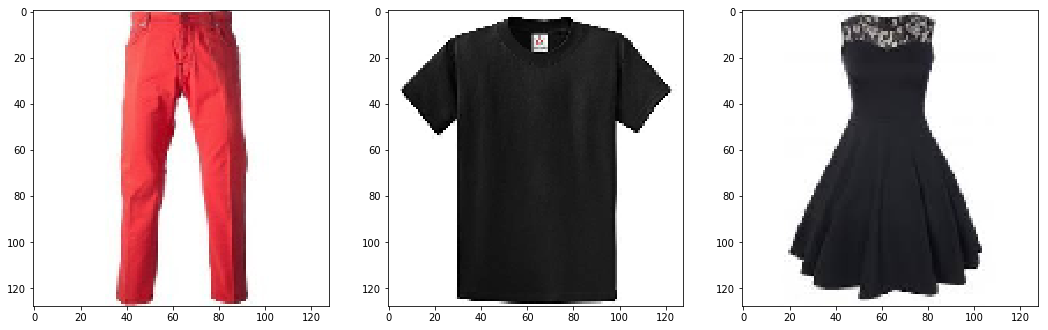

In [21]:
from keras.models import load_model
cur_model = load_model('./best_model.h5')
test(cur_model)

### With class weight

In [12]:
from collections import Counter
from functools import reduce
y_flatten = reduce(lambda x,y: x+y,labe_list)
Counter(y_flatten)

Counter({'black': 344,
         'blue': 1111,
         'dress': 766,
         'jeans': 700,
         'red': 712,
         'shirt': 701})

In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', mlb.classes_, y_flatten)
class_weight

array([ 2.0998062 ,  0.65016502,  0.94299391,  1.03190476,  1.01451311,
        1.03043272])

In [24]:
import keras 
batch_size = 32
epochs = 5
best_model_path = './best_model_class_weight.h5'
checkpoint = keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1)
model = custom_vgg_model(input_shape=x[0].shape, output_shape=len(y[0]))

history = model.fit(x=x_train,
                    y=y_tain,
                    validation_data=(x_val,y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    class_weight=class_weight,
                    callbacks=[checkpoint])

Train on 1733 samples, validate on 434 samples
Epoch 1/5
1733/1733 [==============================] - 10s 6ms/step - loss: 0.5664 - acc: 0.7105 - val_loss: 0.7113 - val_acc: 0.6436
Epoch 2/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.3693 - acc: 0.8300 - val_loss: 0.2857 - val_acc: 0.8817
Epoch 3/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.1455 - acc: 0.9498 - val_loss: 0.0684 - val_acc: 0.9727
Epoch 4/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.0601 - acc: 0.9799 - val_loss: 0.0238 - val_acc: 0.9912
Epoch 5/5
1733/1733 [==============================] - 7s 4ms/step - loss: 0.0582 - acc: 0.9835 - val_loss: 0.1758 - val_acc: 0.9697


['black' 'blue' 'dress' 'jeans' 'red' 'shirt']
red_jeans ['0.0290', '0.0212', '0.5837', '0.0252', '0.9714', '0.4129'] ['dress', 'red']
black_shirt ['0.7886', '0.1640', '0.0308', '0.8572', '0.0460', '0.1304'] ['black', 'jeans']
black_dress ['0.7824', '0.2057', '0.1221', '0.9099', '0.0133', '0.0121'] ['black', 'jeans']


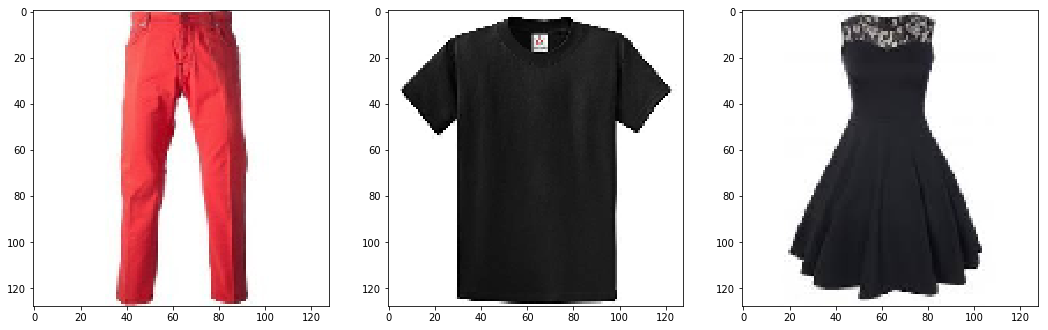

In [25]:
from keras.models import load_model
cur_model = load_model('./best_model_class_weight.h5')
test(cur_model)